# Simulating a spectrometer limb observations

In some circumstances, a spectrometer sensor on board of a satellite might be observing diagonally through the halo that surrounds the Earth (limb-viewing). In this post, we are going to model the atmosphere at a given tangent height (defined as the minimum distance between the light path of measurement and the oblate Earth surface) and calculate a spectrometer response given its instrumental spectral response function (ISRF).  
We are going to simulate atmosphere's radiative transfer model by means of [RFM](http://eodg.atm.ox.ac.uk/RFM/), a Fortran application for which I showed a compilation approach in a [previous post](https://notes.stefanomattia.net/2022/12/16/Compiling-Fortran-applications-on-macOS-Monterey/).

## Radiative Transfer Model

To model the atmosphere radiative transfer properties, we are going to make use of RFM. This application, once compiled, is quite straightforward to use: the program will expect a file `rfm.drv` in the local directory. This is the Driver Table, an editable text file which controls the RFM operation. Unless otherwise directed (via the Driver Table), all output files will also be created in the local directory. A single run of the RFM typically produces spectra for one or more viewing geometries over one or more spectral ranges, as specified in this Driver File (from [Running the RFM](http://eodg.atm.ox.ac.uk/RFM/sum/rfm_running.html)).

Let's then create a driver file for our purposes:
```
*HDR
RFM: Near IR Limb Transmittance for Sentinel 5P
*FLG
   TRA OPT REX
*SPC
   4800.0 5750.0 0.002
*GAS
   H2O CO2 CH4 O2 O3 N2O NO2 OH HCL
*ATM
   ./ATM/US_Std_Atmosphere.atm
*TAN
   50
*HIT
   ./HITRAN/HITRAN2016_190930.hit
*END
```

And here's what all that means:
* the HDR section specifies an header Text for the generated files
* the FLG options control the RFM output files, in this case we set:
    * TRA, for Write Transmission spectra
    * OPT, for Write Optical Depth spectra
    * REX, to Include Rayleigh extinction
* the SPC section defines range and resolution of the RFM output spectra, in this case we are using a wavenumber range of 4800-5750 with a resolution of 0.002
* the GAS section lists the absorbing species required for calculations: H<sub>2</sub>O, CO<sub>2</sub>, CH<sub>4</sub>, O<sub>2</sub>, O<sub>3</sub>, N<sub>2</sub>O, NO<sub>2</sub>, OH, and HCL in our case
* the ATM section specifies the location of the Atmospheric profile data
* the TAN option specifies the tangent height in the limb-viewing case
* the HIT section specifies the location of the RFM spectroscopic data ([HITRAN](https://www.sciencedirect.com/science/article/pii/S0022407317301073))
* END: end of the driver file


With the driver file ready, we can finally launch RFM and compute our model:
```
smattia@EST01109520:~/src/rfm $ ./rfm
 R-RFM:    Program RFM v4.35_01MAY
 Optional ID to be appended to filenames (<CR>=none):

 R-RFM:    Commencing Wide Mesh Calculation
           1         951
           2         951
           3         951
 [...]
          951         951
 R-RFM:          2 Warning messages in RUNLOG file
 R-RFM:    Successful completion.
 ```

The generated `tra_50000.asc` file contains our transmission spectra:

```
! Transmission  calc. for Limb Path Tang.Hgt =50.0      km by RFM v.4.35_01MAY  
! RFM: Near IR Limb Transmittance for Sentinel 5P           
!No.Pts  Lower_Wavenumber   Delta_Wavenumber  Upper_Wavenumber  Label           
 475001   4800.0000000000      0.0020000000   5750.0000000000 'Transmission' 
  0.999973655      0.999973476      0.999972641      0.999969721      0.999962568      0.999950767      0.999939084      0.999935627      0.999943197      0.999955833      0.999965966      0.999971211      0.999972999 [...]    
```

To load these data into a numpy array we can make use of the `genfromtxt` function:

In [1]:
import numpy as np

transmission_spectrum = np.genfromtxt('tra_50000.asc',
                                      skip_header=4,
                                      invalid_raise=False,
                                      filling_values=np.NaN,
                                      dtype=np.float64)
transmission_spectrum = transmission_spectrum.flatten()
print("Spectrum: " + str(transmission_spectrum))
print("Datapoints: " + str(transmission_spectrum.size))

Spectrum: [0.99997366 0.99997348 0.99997264 ... 0.99994612 0.99994612 0.999946  ]
Datapoints: 475000


/var/folders/sv/5ks7tk492yx6sr_r41zxxggd7cpb4z/T/ipykernel_95050/3743752494.py:3: ConversionWarning: Some errors were detected !
    Line #955 (got 1 columns instead of 500)
  transmission_spectrum = np.genfromtxt('tra_50000.asc',


The function raises a warning, most likely because of the peculiar formatting of the original file. Let's ignore it for now, at worse we would only lose one data point of the 475000 available.

Let's see how it looks like.

First, let's convert our wavenumber index into wavelengths, and let's increase the resolution by using a 0.001 step.

In [2]:
# define the wavenumbers index
wavenumber_range = np.array([4800, 5750, 0.002])
wavenumbers = np.arange(wavenumber_range[0],
                        transmission_spectrum.size * wavenumber_range[2] +
                        wavenumber_range[0],
                        wavenumber_range[2],
                        dtype=np.float64)

# convert to wavelengths
wavelengths = np.flipud((1 / wavenumbers) * 10000000)

# resample wavelengths
Lmin = round(wavelengths.min(), 2)
Lmax = round(wavelengths.max(), 2)
wavelengths_resample_step = 0.001
wavelengths_resampled = np.arange(Lmin, Lmax, wavelengths_resample_step)
print(wavelengths_resampled)

[1739.13       1739.131      1739.132      ... 2083.32699999 2083.32799999
 2083.32899999]


Next, we want to interpolate the generated transmission spectra to our finer wavelengths index. For that, we can use the `interp1d` function from the SciPy library.

In [3]:
from scipy.interpolate import interp1d

f = interp1d(wavelengths, transmission_spectrum, bounds_error=False)
transmission_spectrum_interpolated = f(wavelengths_resampled)

Plotting our transmission spectrum is now easy:

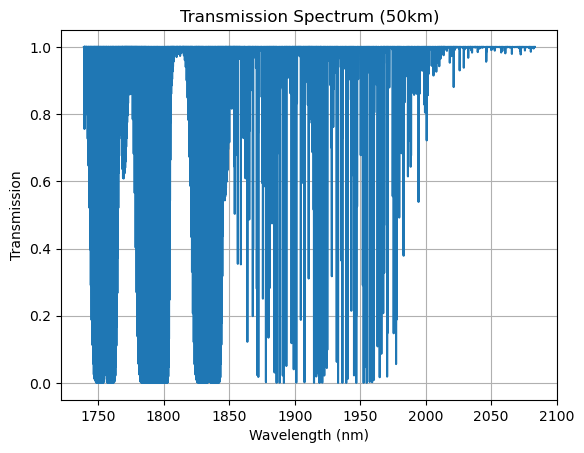

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(wavelengths_resampled, transmission_spectrum_interpolated)

ax.set(xlabel='Wavelength (nm)',
       ylabel='Transmission',
       title='Transmission Spectrum (50km)')
ax.grid()
plt.show()

Now that we have our spectra, let's focus on modeling our instrument.

## Instrument model

The instrumental spectral response function (ISRF), also known as “instrument transfer function” or just “slit function”, describes the instrument spectral response to a monochromatic stimulus, basically its pixels' signal as a function of wavelength of the incoming light. One of the simplest possible parameterizations of the ISRF is a Gaussian, which often describes the measured line shapes fairly well by only one free parameter, σ, plus an asymmetry parameter if needed. In reality, modeling the ISRF is much more complicated and involves on-ground and in-flight repeated measurements (see [Determination of the TROPOMI-SWIR instrument spectral response function](https://www.researchgate.net/publication/326259400_Determination_of_the_TROPOMI-SWIR_instrument_spectral_response_function))

Let's then assume that the full-width at half-maximum (FWHM) of the response function for our instrument is: 350nm, the sigma of the normal distribution modeling the ISRF can be then derived as[<sup>1</sup>](#fn1): 

In [5]:
import math

FWHM = 350
sigma = FWHM / (2 * math.sqrt(2 * math.log(2)))
print(sigma)

148.63131505040334


And the ISRF as:

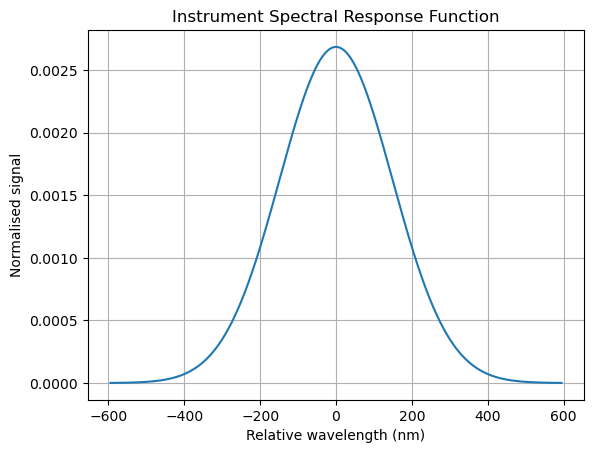

In [13]:
import scipy.stats as stats

x = np.linspace(-4 * sigma, 4 * sigma, wavelengths_resampled.size)
ISRF = stats.norm.pdf(x, 0, sigma)
fig, ax = plt.subplots()

ax.plot(x, ISRF)
ax.set(xlabel='Relative wavelength (nm)',
       ylabel='Normalised signal',
       title='Instrument Spectral Response Function')
ax.grid()
plt.show()

## Convolution

We can now convolve the transmission spectrum with the instrument ISRF. I chose to use the `gaussian_filter1d` function from the SciPy libray because of its ease of use: if the order parameter is not specified, this function performs convolution with a Gaussian kernel. 

In [7]:
from scipy import ndimage

response = ndimage.gaussian_filter1d(transmission_spectrum_interpolated, sigma)

We can now plot the instrument response against the original transmission spectrum to get a rough idea of how the instrument behaves:

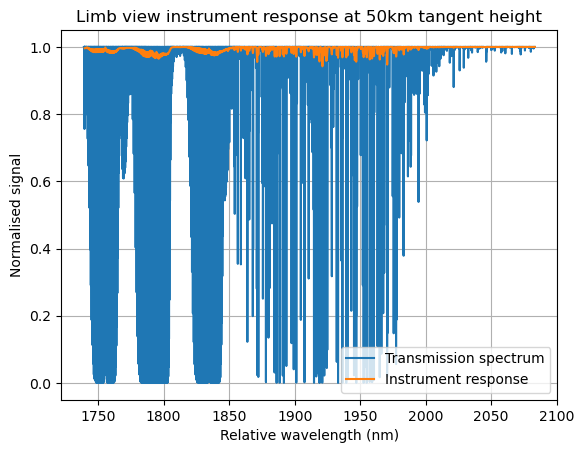

In [15]:
fig, ax = plt.subplots()
ax.plot(wavelengths_resampled,
        transmission_spectrum_interpolated,
        label="Transmission spectrum")

ax.plot(wavelengths_resampled, response, label="Instrument response")

ax.set(xlabel='Relative wavelength (nm)',
       ylabel='Normalised signal',
       title='Limb view instrument response at 50km tangent height')

legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('white')

ax.grid()

plt.show()

## Conclusions

This topic is quite complex and of course this post is not meant to be a comprehensive treatise on the subject.   
There is so much I still would like to do:

1. explore different convolution techniques, including using FFT functions.
2. understand the different resampling and interpolating options that the NumPy and SciPy libraries offer.
3. more complex modeling of the ISRF and comparing the results with a simple Gaussian kernel.  

More to come!


<span id="fn1">[1] https://en.wikipedia.org/wiki/Full_width_at_half_maximum</span>


_This post was written entirely in a Jupyter notebook. You can download it on my [GitHub repository](https://github.com/stefanomattia/jupyter-notebooks/tree/master/earth-observation)._